In [1]:
from tdc.single_pred import Epitope
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, precision_score, recall_score, accuracy_score
from copy import deepcopy
torch.manual_seed(1)
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt  
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score 
from tdc.multi_pred import AntibodyAff
from collections import defaultdict
from tqdm import tqdm
from torch.distributions import Categorical, Normal
import numpy as np
from scipy.integrate import quad
from sklearn.neighbors import KernelDensity

In [2]:
from matplotlib import pyplot
from numpy.random import normal
from numpy import hstack
from numpy import asarray
from numpy import exp
from sklearn.neighbors import KernelDensity
import statsmodels.api as sm

In [3]:
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import scipy as scp
from scipy import fftpack
from scipy import signal
import pickle
import os
from IPython.display import Math, Latex
from IPython.core.display import Image
import seaborn as sns
from scipy import stats
from statistics import variance

In [4]:
# data = AntibodyAff(name = 'Protein_SAbDab')
# split = data.get_split()

In [4]:
data =  Epitope(name = 'IEDB_Jespersen')
split = data.get_split()

Found local copy...
Loading...
Done!


In [5]:
train_data = split['train']
valid_data = split['valid']
test_data = split['test']

In [6]:
train_data

,Antigen_ID,Antigen,Y
0,Protein 2,MSDLTDIQEDITRHEQQLIVARQKLKDAERAVEVDPDDVNKNTLQA...,"[312, 313, 314, 315, 316, 317, 318, 319, 320, ..."
1,Protein 3,MAEGFAANRQWIGPEEAEELLDFDIAIQMNEEGPLNPGVNPFRVPG...,"[585, 586, 587, 588, 589, 590, 591, 592, 593, ..."
2,Protein 4,MSKKPGGPGKSRAVNMLKRGMPRVLSLTGLKRAMLSLIDGRGPTRF...,"[811, 812, 813, 814, 815, 816, 817, 818, 819, ..."
3,Protein 5,MKLLILTCLVAVALARPKHPIKHQGLPQEVLNENLLRFFVAPFPEV...,"[55, 56, 57, 58, 59, 60, 61, 62, 63, 64]"
4,Protein 7,MNTLLLTLVVVTIVCLDFGYTTKCLTKFSPGLQTSQTCPAGQKICF...,"[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 3..."
...,...,...,...
2206,Protein 3153,MSTVKAPTLPASIFRAYDIRRVVGDTLTAETAYWIGRAIGSESLAR...,"[260, 261, 262, 263, 264, 265, 266, 267, 268, ..."
2207,Protein 3154,DHTLFNTHSITTTTTMAKLTILVALALFLLAAHASARQQWEFQGDR...,"[162, 163, 164, 165, 166, 167, 168, 169, 170, ..."
2208,Protein 3155,MTNETIDQTTTPDQTDFVPQRFINNLQVAFIKVDNAVASFDPDQKP...,"[722, 723, 724, 725, 726, 727, 728, 729, 730, ..."
2209,Protein 3156,CLSPGSSCSPTSYNCCRSCNPYSRKC,"[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]"


In [7]:
seqs = train_data['Antigen'].tolist()

In [8]:
seqs[3]

'MKLLILTCLVAVALARPKHPIKHQGLPQEVLNENLLRFFVAPFPEVFGKEKVNELSKDIGSESTEDQAMEDIKQMEAESISSSEEIVPNSVEQKHIQKEDVPSERYLGYLEQLLRLKKYKVPQLEIVPNSAEERLHSMKEGIHAQQKEPMIGVNQELAYFYPELFRQFYQLDAYPSGAWYYVPLGTQYTDAPSFSDIPNPIGSENSEKTTMPLW'

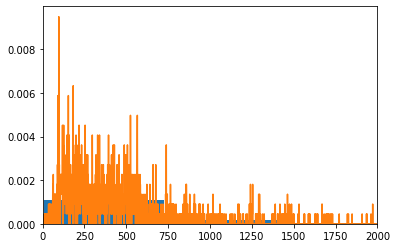

In [43]:
seqs = train_data['Antigen'].tolist()
seqs = [len(seq)*1.0 for seq in seqs]
minlen = min(seqs)
maxlen = max(seqs)
seqs.remove(maxlen)
maxlen = max(seqs)
values = asarray([value for value in range(0, 2000)])
values = values.reshape((len(values), 1))

sample = np.array(seqs)
sample = sample.reshape((len(sample), 1))
model = KernelDensity(bandwidth=1, kernel='linear')
model.fit(sample)
probabilities = model.score_samples(values)
probabilities = exp(probabilities)
pyplot.hist(sample, density=True)
pyplot.plot(values[:], probabilities)
pyplot.xlim(0, 2000)
pyplot.show()


In [42]:
kde = sm.nonparametric.KDEUnivariate(sample)
kde.fit(kernel='uni', bw=100, fft=False)
mean1 = np.dot(kde.density, kde.support) / kde.density.sum()
mean2 = scipy.integrate.quad(lambda x: kde.evaluate(x)  * x, kde.support[0], kde.support[-1])
print('TL;DR version - Mean:', mean1)
print('Integration version - Mean:', mean2)

print('TL;DR version - Variance:', np.dot(kde.density, kde.support**2) / kde.density.sum() - mean1**2)
print('Integration version - Variance:', scipy.integrate.quad(lambda x: kde.evaluate(x)  * x**2, kde.support[0], kde.support[-1])[0] - mean2[0]**2)

TL;DR version - Mean: 624.1984734684842
Integration version - Mean: (nan, nan)
TL;DR version - Variance: 569500.5456861544
Integration version - Variance: nan


Mean:
Integration: 623.9941176470431
Monte Carlo: 624.2214106281475

Variance
Integration: 575582.0420468501
Monte Carlo: 576234.8216550958



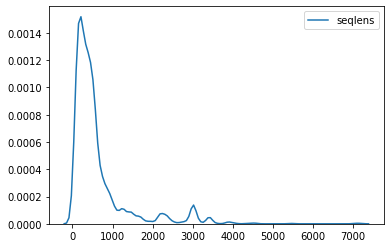

In [48]:
kde = KernelDensity(kernel='gaussian', bandwidth=100).fit(sample)
pdf = lambda x : np.exp(kde.score_samples([[x]]))[0]
mean_integration = quad(lambda x: x * pdf(x), a=-np.inf, b=np.inf)[0]
variance_integration = quad(lambda x: (x ** 2) * pdf(x), a=-np.inf, b=np.inf)[0] - mean_integration ** 2
n_samples = 10000000
samples = kde.sample(n_samples)

mean_mc = samples.mean()
variance_mc = samples.var()


print('Mean:\nIntegration: {}\nMonte Carlo: {}\n'.format(mean_integration, mean_mc))
print('Variance\nIntegration: {}\nMonte Carlo: {}\n'.format(variance_integration, variance_mc))
plt.figure()
ax = sns.kdeplot(np.array(seqs), label='seqlens')

In [55]:
type(seqs)

list

Mean:
Integration: 14.44504748982286
Monte Carlo: 14.445024951964346

Variance
Integration: 30.18320817278874
Monte Carlo: 30.213389873853266



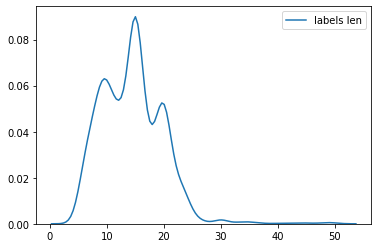

In [61]:
labels = train_data['Y'].tolist()
labels = [len(y) for y in labels]
minlen = min(labels)
maxlen = max(labels)
ysample = np.array(labels)
ysample = ysample.reshape((len(ysample), 1))

kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(ysample)
pdf = lambda x : np.exp(kde.score_samples([[x]]))[0]
mean_integration = quad(lambda x: x * pdf(x), a=-np.inf, b=np.inf)[0]
variance_integration = quad(lambda x: (x ** 2) * pdf(x), a=-np.inf, b=np.inf)[0] - mean_integration ** 2
n_samples = 10000000
samples = kde.sample(n_samples)

mean_mc = samples.mean()
variance_mc = samples.var()
print('Mean:\nIntegration: {}\nMonte Carlo: {}\n'.format(mean_integration, mean_mc))
print('Variance\nIntegration: {}\nMonte Carlo: {}\n'.format(variance_integration, variance_mc))
plt.figure()
ax = sns.kdeplot(np.array(labels), label='labels len')



In [63]:
kde = sm.nonparametric.KDEUnivariate(ysample)
kde.fit(kernel='uni', bw=1, fft=False)
mean1 = np.dot(kde.density, kde.support) / kde.density.sum()
mean2 = scipy.integrate.quad(lambda x: kde.evaluate(x)  * x, kde.support[0], kde.support[-1])
print('TL;DR version - Mean:', mean1)
print('Integration version - Mean:', mean2)

print('TL;DR version - Variance:', np.dot(kde.density, kde.support**2) / kde.density.sum() - mean1**2)
print('Integration version - Variance:', scipy.integrate.quad(lambda x: kde.evaluate(x)  * x**2, kde.support[0], kde.support[-1])[0] - mean2[0]**2)

TL;DR version - Mean: 14.44540223806401
Integration version - Mean: (nan, nan)
TL;DR version - Variance: 29.562605894920154
Integration version - Variance: nan


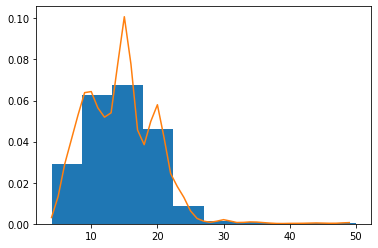

In [62]:
values = asarray([value for value in range(minlen, maxlen)])
values = values.reshape((len(values), 1))

sample = np.array(labels)
sample = sample.reshape((len(labels), 1))
model = KernelDensity(bandwidth=1, kernel='gaussian')
model.fit(sample)
probabilities = model.score_samples(values)
probabilities = exp(probabilities)
pyplot.hist(sample, density=True)
pyplot.plot(values[:], probabilities)
# pyplot.xlim(0, 2000)
pyplot.show()

In [72]:
val, cnt = np.unique(labels, return_counts=True)
prop = cnt / len(labels)
EV = [val[i]*prop[i] for i in range(len(val))]
sum(EV)

14.445047489823608

In [80]:
rewards_episode = [1,0,0,1,0,0,0,1,1,1,1,1,0,0,0,0,1,0,0,0,0,1,1,1,1,1]
gamma = 0.99
R = 0
rewards = []
for r in rewards_episode[::-1]:
        R = r + gamma * R
        rewards.insert(0,R)
rewards = torch.FloatTensor(rewards)
print(rewards)
rewards = (rewards - rewards.mean()) / (rewards.std() + float(np.finfo(np.float32).eps))
rewards

tensor([11.3583, 10.4629, 10.5686, 10.6753,  9.7731,  9.8718,  9.9715, 10.0722,
         9.1639,  8.2463,  7.3195,  6.3834,  5.4377,  5.4927,  5.5481,  5.6042,
         5.6608,  4.7079,  4.7554,  4.8035,  4.8520,  4.9010,  3.9404,  2.9701,
         1.9900,  1.0000])


tensor([ 1.5604,  1.2571,  1.2929,  1.3291,  1.0235,  1.0569,  1.0907,  1.1248,
         0.8171,  0.5064,  0.1925, -0.1246, -0.4448, -0.4262, -0.4075, -0.3885,
        -0.3693, -0.6920, -0.6759, -0.6597, -0.6432, -0.6266, -0.9520, -1.2806,
        -1.6125, -1.9478])

In [105]:
a = torch.FloatTensor([2,3])
b = torch.FloatTensor([1,3])
a+b

tensor([3., 6.])

In [78]:
# def to_protlists(data):

#     protlists = list()
#     temp_dict = data.to_dict("records")
#     for record in temp_dict:
#         protlist = defaultdict(list)
#         antigen = record['Antigen_ID']
#         seq = record['Antigen']
#         desc = ''
#         protlist[antigen].append(desc)
#         protlist[antigen].append(seq)

#         protlists.append(protlist)
        
#     return protlists

In [79]:
lst = train_data['Antigen'].tolist()
maxlen = max([len(A) for A in lst])
maxlen

34350

In [89]:
X = 'Antigen'

In [82]:
def data2vocab(data):
	length = len(data)
	vocab_set = set()
	total_length, positive_num = 0, 0
	for i in range(length):
		antigen = data[X][i]
		vocab_set = vocab_set.union(set(antigen))
		Y = data['Y'][i]
		assert len(antigen) > max(Y)
		total_length += len(antigen)
		positive_num += len(Y)
	return vocab_set, positive_num / total_length

In [83]:
train_vocab, train_positive_ratio = data2vocab(train_data)
valid_vocab, valid_positive_ratio = data2vocab(valid_data)
test_vocab, test_positive_ratio = data2vocab(test_data)

In [84]:
vocab_set = train_vocab.union(valid_vocab)
vocab_set = vocab_set.union(test_vocab)
vocab_lst = list(vocab_set)
# logger

In [82]:
def onehot(idx, length):
	lst = [0 for i in range(length)]
	lst[idx] = 1
	return lst 

def zerohot(length):
	return [0 for i in range(length)]

# what is the maxlength here
def standardize_data(data, vocab_lst, maxlength = 300):
	length = len(data)
	standard_data = []
	for i in range(length):
		antigen = data[X][i]
		Y = data['Y'][i] 
		sequence = [onehot(vocab_lst.index(s), len(vocab_lst)) for s in antigen] 
		labels = [0 for i in range(len(antigen))]
		mask = [True for i in range(len(labels))] # labels and mask have the same length
		sequence += (maxlength-len(sequence)) * [zerohot(len(vocab_lst))] #pad to consistent length
		labels += (maxlength-len(labels)) * [0] 
		mask += (maxlength-len(mask)) * [False] # pad to maxlength
		for y in Y:
			labels[y] = 1 		
		sequence, labels, mask = sequence[:maxlength], labels[:maxlength], mask[:maxlength]
		sequence, labels, mask = torch.FloatTensor(sequence), torch.FloatTensor(labels), torch.BoolTensor(mask) 
		# print(sequence.shape, labels.shape, mask.shape)
        # sequence is 2D, labels and mask are 1D
		standard_data.append((sequence, labels, mask))
	return standard_data 

In [86]:
# def standardize_data2(data, vocab_lst):
# 	length = len(data)
# 	standard_data = []
# 	for i in range(length):
# 		antigen = data[X][i]
# 		Y = data['Y'][i] 
# 		sequence = [onehot(vocab_lst.index(s), len(vocab_lst)) for s in antigen] 
# 		labels = [0 for i in range(len(antigen))]
# 		mask = [True for i in range(len(labels))] # labels and mask have the same length
# # 		sequence += (maxlength-len(sequence)) * [zerohot(len(vocab_lst))] #pad to consistent length
# # 		labels += (maxlength-len(labels)) * [0] 
# # 		mask += (maxlength-len(mask)) * [False] # pad to maxlength
# 		for y in Y:
# 			labels[y] = 1 		
# # 		sequence, labels, mask = sequence[:maxlength], labels[:maxlength], mask[:maxlength]
# 		sequence, labels, mask = torch.FloatTensor(sequence), torch.FloatTensor(labels), torch.BoolTensor(mask) 
# 		# print(sequence.shape, labels.shape, mask.shape)
#         # sequence is 2D, labels and mask are 1D
# 		standard_data.append((sequence, labels, mask))
# 	return standard_data 

In [84]:
# train_data_stand2 = standardize_data2(train_data, vocab_lst)
# valid_data_stand2 = standardize_data2(valid_data, vocab_lst)
# test_data_stand2 = standardize_data2(test_data, vocab_lst)
vocab_lst = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'X', 'B', 'Z', 'J']

In [107]:
train_data_stand = standardize_data(train_data, vocab_lst)
valid_data_stand = standardize_data(valid_data, vocab_lst)
test_data_stand = standardize_data(test_data, vocab_lst)

In [108]:
class dataset(Dataset):
	def __init__(self, data):
		self.sequences = [i[0] for i in data]
		self.labels = [i[1] for i in data]
		self.mask = [i[2] for i in data] 

	def __getitem__(self, index):
		return self.sequences[index], self.labels[index], self.mask[index]

	def __len__(self):
		return len(self.labels)

In [109]:
train_set = dataset(train_data_stand)
valid_set = dataset(valid_data_stand)
test_set = dataset(test_data_stand)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

In [110]:
for sequence, labels, mask in tqdm(train_loader):
    
    print(sequence.shape, labels.shape, mask.shape)
# for batch, (x,y,z) in enumerate(train_loader):
#         print(batch)

100%|██████████| 139/139 [00:00<00:00, 1440.68it/s]

torch.Size([16, 300, 24]) torch.Size([16, 300]) torch.Size([16, 300])
torch.Size([16, 300, 24]) torch.Size([16, 300]) torch.Size([16, 300])
torch.Size([16, 300, 24]) torch.Size([16, 300]) torch.Size([16, 300])
torch.Size([16, 300, 24]) torch.Size([16, 300]) torch.Size([16, 300])
torch.Size([16, 300, 24]) torch.Size([16, 300]) torch.Size([16, 300])
torch.Size([16, 300, 24]) torch.Size([16, 300]) torch.Size([16, 300])
torch.Size([16, 300, 24]) torch.Size([16, 300]) torch.Size([16, 300])
torch.Size([16, 300, 24]) torch.Size([16, 300]) torch.Size([16, 300])
torch.Size([16, 300, 24]) torch.Size([16, 300]) torch.Size([16, 300])
torch.Size([16, 300, 24]) torch.Size([16, 300]) torch.Size([16, 300])
torch.Size([16, 300, 24]) torch.Size([16, 300]) torch.Size([16, 300])
torch.Size([16, 300, 24]) torch.Size([16, 300]) torch.Size([16, 300])
torch.Size([16, 300, 24]) torch.Size([16, 300]) torch.Size([16, 300])
torch.Size([16, 300, 24]) torch.Size([16, 300]) torch.Size([16, 300])
torch.Size([16, 300,

In [104]:
embedding = nn.Embedding(10, 3)
i = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
o = embedding(i)
i.shape, o.shape

(torch.Size([2, 4]), torch.Size([2, 4, 3]))

In [51]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

In [21]:
# train_data_stand[0][2].shape

torch.Size([300])

In [28]:
def plot(label_lst, predict_lst, name):

    fpr, tpr, thresholds = metrics.roc_curve(label_lst, predict_lst, )
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig(name)

In [255]:
loss = nn.BCEWithLogitsLoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(input, target)
input, target, output, output.backward()

(tensor([-0.2493,  0.2576, -0.0780], requires_grad=True),
 tensor([1., 0., 0.]),
 tensor(0.7702, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 None)

In [256]:
n[0] + output

tensor(-0.5674, grad_fn=<AddBackward0>)

In [241]:
output = torch.FloatTensor([output.item()])
c, c.shape, output, output.shape

(tensor([[-1.1693, -1.0862,  0.2509, -2.3874]]),
 torch.Size([1, 4]),
 tensor([1.2722]),
 torch.Size([1]))

In [245]:
output = torch.unsqueeze(output, 0)
output.shape

torch.Size([1, 1])

In [251]:

torch.cat((c,output), dim=1)

tensor([[-1.1693, -1.0862,  0.2509, -2.3874,  1.2722]])

In [168]:
m = Categorical(torch.tensor([ 0.25, 0.25, 0.25, 0.25]))
m.sample()

tensor(0)

In [208]:
b = torch.randn(4, 1)
c = torch.randn(1, 4)

In [209]:
b, b.shape, c, c.shape

(tensor([[-0.3045],
         [-0.1741],
         [ 0.1884],
         [-1.2225]]),
 torch.Size([4, 1]),
 tensor([[-1.1693, -1.0862,  0.2509, -2.3874]]),
 torch.Size([1, 4]))

In [210]:
loss = torch.mul(b, c).mul(-1)
m = torch.sum(loss, dim=-1)
loss, m

(tensor([[-0.3561, -0.3308,  0.0764, -0.7271],
         [-0.2035, -0.1891,  0.0437, -0.4156],
         [ 0.2203,  0.2046, -0.0473,  0.4498],
         [-1.4295, -1.3279,  0.3067, -2.9186]]),
 tensor([-1.3376, -0.7645,  0.8275, -5.3694]))

In [254]:
n = torch.sum(torch.mul(b, c).mul(-1), -1)
n[0]

tensor(-1.3376)

In [196]:
b = torch.tensor([[0, 1], [2, 3]])
b2 = torch.reshape(b, (-1,))
b3 = torch.unsqueeze(b2, 1)
b, b2, b2.shape, b3, b3.shape

(tensor([[0, 1],
         [2, 3]]), tensor([0, 1, 2, 3]), torch.Size([4]), tensor([[0],
         [1],
         [2],
         [3]]), torch.Size([4, 1]))

In [257]:
rewards = []
rewards.insert(0,2)
rewards.insert(0,3)
rewards

[3, 2]

In [216]:
a = torch.randn(5,1)
torch.log(a)

tensor([[-0.8064],
        [-2.4553],
        [    nan],
        [    nan],
        [-0.1831]])

In [111]:
class RNN(nn.Module):
    def __init__(self, name, hidden_size, input_size, num_layers = 2):
        super(RNN, self).__init__()
        self.name = name 
        self.hidden_size = hidden_size
        self.input_size = input_size 
        self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
            input_size=input_size,
            hidden_size=hidden_size,         # rnn hidden unit
            num_layers=num_layers,           # number of rnn layer
            batch_first=True,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(hidden_size, 1)
        criterion = torch.nn.BCEWithLogitsLoss()  
        self.opt = torch.optim.Adam(self.parameters(), lr=1e-3)
    
    
    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state

        # choose r_out at the last time step
        out = self.out(r_out)
        out = out.squeeze(-1)
        return out
    
    def learn(self, sequence, labels, mask):
        prediction_lst = []
        label_lst = []
        prediction = self.forward(sequence)
        pred = torch.sigmoid(prediction)
#         print(prediction, prediction.shape)
#         print(pred, pred.shape)
#         print(labels)
#         print(mask)
        for pred, label, msk in zip(prediction, labels, mask):
                num = sum(msk.tolist()) 
                pred = pred.tolist()[:num] 
                label = label.tolist()[:num] 
                label_lst.extend(label)
                prediction_lst.extend(pred)
#         print(prediction_lst)
        sort_pred = deepcopy(prediction_lst)
        sort_pred.sort() 
        threshold = sort_pred[int(len(sort_pred)*0.9)]
#         print(threshold, type(threshold))
#         print(type(prediction_lst))
#         threshold = 0.5
        float2binary = lambda x:0 if x<threshold else 1
        binary_pred_lst = list(map(float2binary, prediction_lst))
#         print(binary_pred_lst, len(binary_pred_lst))
        
#         print("size", prediction.shape, labels.shape, mask.shape)
        criterion = torch.nn.BCEWithLogitsLoss(size_average=True, weight = mask)  
        
        loss = criterion(prediction, labels)
#         print(loss)
        self.opt.zero_grad() 
        loss.backward() 
        self.opt.step()
        
    def test(self, test_loader, name):
        label_lst, prediction_lst = [], []
        for sequence, labels, mask in test_loader:
            prediction = self.forward(sequence)
            prediction = torch.sigmoid(prediction)
#             print(prediction)
            for pred, label, msk in zip(prediction, labels, mask):
                num = sum(msk.tolist()) 
                pred = pred.tolist()[:num] 
                label = label.tolist()[:num] 
                label_lst.extend(label)
                prediction_lst.extend(pred)
#         print(prediction_lst)
        sort_pred = deepcopy(prediction_lst)
        sort_pred.sort() 
        threshold = sort_pred[int(len(sort_pred)*0.9)]
#         print(threshold, type(threshold))
#         print(type(prediction_lst))
        float2binary = lambda x:0 if x<threshold else 1
        binary_pred_lst = list(map(float2binary, prediction_lst))
#         plot(label_lst, prediction_lst, name)
        print('roc_auc', roc_auc_score(label_lst, prediction_lst), 
    		  'F1', f1_score(label_lst, binary_pred_lst), 
    		  'prauc', average_precision_score(label_lst, binary_pred_lst))
        

In [112]:
model = RNN(name = 'Epitope', hidden_size=100, input_size=len(vocab_lst))
epoch = 20
for ep in range(epoch):
    for sequence, labels, mask in train_loader:
#         print(sequence.shape, labels.shape, mask.shape)
        model.learn(sequence, labels, mask)
    model.test(test_loader, name = model.name + '_' + str(ep) + '.png')

roc_auc 0.5335994818737018 F1 0.06693212831640642 prauc 0.04190879541411918
roc_auc 0.5360316308800153 F1 0.06567938794684801 prauc 0.041796298350668726
roc_auc 0.5164668774067702 F1 0.057710374446383036 prauc 0.04116941726221139
roc_auc 0.5336911573638689 F1 0.06325772826913612 prauc 0.041589450022538124
roc_auc 0.5375527852011784 F1 0.06729306487695749 prauc 0.04194198086529447
roc_auc 0.5392081076594782 F1 0.06997762863534676 prauc 0.04219818370173563
roc_auc 0.5426586213221264 F1 0.07167785234899329 prauc 0.04236946336253772
roc_auc 0.5555959554815755 F1 0.07355704697986577 prauc 0.04256690888031689
roc_auc 0.5607043648326338 F1 0.07633109619686801 prauc 0.04287399024873452
roc_auc 0.5668140269103071 F1 0.0796420581655481 prauc 0.043264877232858226
roc_auc 0.5691908863245412 F1 0.0807158836689038 prauc 0.04339734688316985
roc_auc 0.5715113761376702 F1 0.08214765100671141 prauc 0.04357831250705092
roc_auc 0.5779515725023855 F1 0.08420581655480983 prauc 0.043847139124524155
roc_auc 0